In [1]:
import PyKDL
import kdl_parser_py.urdf
import pickle
import torch
import sys
import cv2 as cv
import h5py
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
np.set_printoptions(suppress=True)


In [10]:
act_path = "/home/zfei/code/act-plus-plus/"
sys.path.append(act_path)
from policy import ACTPolicy
from brl_constants import TASK_CONFIGS

ckpt_path = "/mnt/data1/act/act_demo_scara_whiteboard_updown_pick_one/rgb_up_and_down/"
ckpt_path = "/mnt/data1/act/act_demo_scara_whiteboard_pick_under_leaf/leaf_block/"

# ckpt_path = "/mnt/data1/act/act_demo_scara_whiteboard_pick_one/rgb/"

config_path = ckpt_path + "config.pkl"
# step = 500000
# policy_model_path = ckpt_path + "policy_step_%i_seed_0.ckpt"%step
policy_model_path = ckpt_path + "policy_step_30000_seed_0.ckpt"

stats_path = ckpt_path + "dataset_stats.pkl"

with open(config_path, "rb") as f:
    policy_config = pickle.load(f)['policy_config']
    print(policy_config)

policy = ACTPolicy(policy_config)
loading_status = policy.deserialize(torch.load(policy_model_path))

with open(stats_path, "rb") as f:
    stats = pickle.load(f)

pre_process_qpos = (
    lambda s_qpos: torch.from_numpy((s_qpos - stats["qpos_mean"]) / stats["qpos_std"])
    .float()
    .cuda()
    .unsqueeze(0)
)
post_process_action = lambda a: a * stats["action_std"] + stats["action_mean"]
BASE_DELAY = 13

print("loading ACT policy success")

{'lr': 1e-05, 'num_queries': 100, 'kl_weight': 10, 'hidden_dim': 512, 'dim_feedforward': 3200, 'lr_backbone': 1e-05, 'backbone': 'resnet18', 'enc_layers': 4, 'dec_layers': 7, 'nheads': 8, 'camera_names': ['wrist', 'wrist_down'], 'vq': False, 'vq_class': None, 'vq_dim': None, 'action_dim': 5, 'state_dim': 4, 'no_encoder': False}
ACT Args:  Namespace(lr=1e-05, lr_backbone=1e-05, batch_size=2, weight_decay=0.0001, epochs=300, lr_drop=200, clip_max_norm=0.1, backbone='resnet18', dilation=False, position_embedding='sine', camera_names=['wrist', 'wrist_down'], enc_layers=4, dec_layers=7, dim_feedforward=3200, hidden_dim=512, dropout=0.1, nheads=8, num_queries=100, pre_norm=False, masks=False, eval=False, onscreen_render=False, ckpt_dir='/mnt/data1/act/act_demo_z1_push_red/ckpt', policy_class='ACT', task_name='act_demo_z1_push_red', seed=0, num_steps=2000, kl_weight=10, chunk_size=None, temporal_agg=False, use_vq=False, vq=False, vq_class=None, vq_dim=None, load_pretrain=False, action_dim=5, 

In [11]:
def pre_proccess_img(img):
    img_torch = torch.from_numpy(img).unsqueeze(0)
    img_torch = torch.einsum("k h w c -> k c h w", img_torch)
    img_torch = (img_torch / 255.0).float().cuda().unsqueeze(0)
    return img_torch

def pre_process_multi_img(curr_images):
    # a list of images [w, h, 3]
    curr_image = np.stack(curr_images, axis=0)
    img_torch = torch.from_numpy(curr_image)
    img_torch = torch.einsum("k h w c -> k c h w", img_torch)
    img_torch = (img_torch / 255.0).float().cuda().unsqueeze(0)
    return img_torch

In [12]:
# h5data_file = "/mnt/data1/act/act_demo_scara_whiteboard_updown_pick_one/2024-03-19_09-10-17-up-down-cam/2024-03-19_09-10-17-up-down-cam/episode_32.hdf5"
h5data_file = "/mnt/data1/act/act_demo_scara_whiteboard_pick_under_leaf/2024-03-20_03-12-10-leafblock/episode_11.hdf5"

with torch.inference_mode():
    with h5py.File(h5data_file, "r") as root:
        index = 0
        qpos_np = root["/observations/qpos"][index]
        img_wrist_up_np = root["/observations/images/wrist"][index]
        img_wrist_down_np = root["/observations/images/wrist_down"][index]

        print("img_wrist_up_np: ",img_wrist_up_np.shape)
        curr_images = [img_wrist_up_np, img_wrist_down_np]

        action_obs_np = root["action"][()]
        qpos = pre_process_qpos(qpos_np)
        curr_images_torch = pre_process_multi_img(curr_images)
        # print("qpos: ",qpos.shape)
        all_actions = policy(qpos, curr_images_torch)
        all_actions = all_actions.squeeze(0).cpu().numpy()

        print("all_actions: ", all_actions.shape)
        print("action_obs_np: ", action_obs_np.shape)

        # actual_action = post_process_action(raw_action)
        # print("actual action %i"%index, actual_action)



img_wrist_up_np:  (480, 640, 3)
all_actions:  (100, 5)
action_obs_np:  (241, 5)


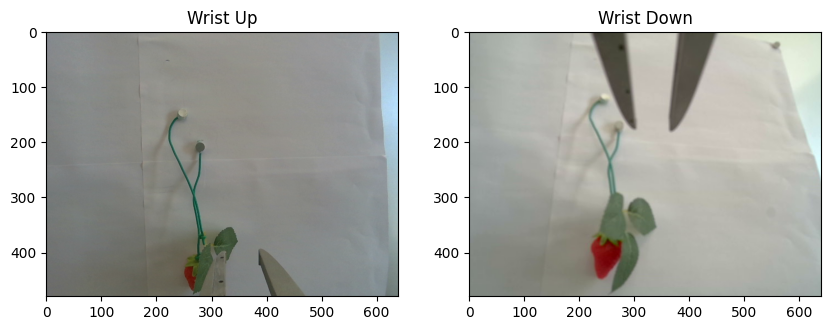

In [13]:
# plot image of wrist up and wrist down on left and right 

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.title('Wrist Up')
plt.imshow(cv.cvtColor(img_wrist_up_np, cv.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.title('Wrist Down')
plt.imshow(cv.cvtColor(img_wrist_down_np, cv.COLOR_BGR2RGB))
plt.show()


In [14]:
joint_states_traj = []
actual_actions = []
for i, raw_action in enumerate(all_actions):
    actual_action = post_process_action(raw_action)
    actual_actions.append(actual_action)
actual_actions = np.asarray(actual_actions)
# print(actual_actions)

policy_step_30000


Text(0.5, 1.0, 'policy_step_30000')

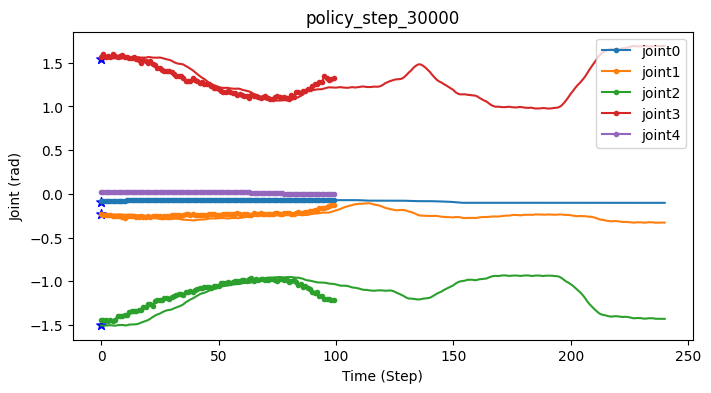

In [15]:
# plot all joint states and label them
plt.figure(figsize=(8, 4))
plt.plot(actual_actions[:, 0], marker=".", label='joint0')
plt.plot(actual_actions[:, 1], marker=".", label='joint1')
plt.plot(actual_actions[:, 2], marker=".", label='joint2')
plt.plot(actual_actions[:, 3], marker=".", label='joint3')
plt.plot(actual_actions[:, 4], marker=".", label='joint4')

plt.xlabel("Time (Step)")
plt.ylabel("Joint (rad)")
plt.legend()


plt.scatter(0, qpos_np[0], marker="*", c="b", s=50, label='joint0')
plt.scatter(0, qpos_np[1], marker="*", c="b", s=50, label='joint1')
plt.scatter(0, qpos_np[2], marker="*", c="b", s=50, label='joint2')
plt.scatter(0, qpos_np[3], marker="*", c="b", s=50, label='joint3')
# plt.plot(np.arange(0, len(qpos_gts), 1), qpos_gts, c="r", label='joint5')

steps_plot = np.arange(0, len(action_obs_np), 1)
plt.plot(steps_plot, action_obs_np[:, 0],  c="C%i"%(0 ), label='joint0')
plt.plot(steps_plot, action_obs_np[:, 1],  c="C%i"%(1 ), label='joint1')
plt.plot(steps_plot, action_obs_np[:, 2],  c="C%i"%(2 ), label='joint2')
plt.plot(steps_plot, action_obs_np[:, 3],  c="C%i"%(3 ), label='joint3')

# get file name from the path policy_model_path
f_name = policy_model_path.split("/")[-1].replace("_seed_0.ckpt", "")
print(f_name)
plt.title(f_name)



In [103]:
# Temperal agg
plt.figure(figsize=(8, 4))
qpos_gts = []
all_actual_actions = []
action_chunking_len = 100
max_act_steps = 175
query_frequency = 1
action_dim = 5
k = 0.01

all_time_actions = torch.zeros([max_act_steps, max_act_steps+action_chunking_len, action_dim]).cuda()
print("all_time_actions: ", all_time_actions.shape)

with torch.inference_mode():
    with h5py.File(h5data_file, "r") as root:
        for index in range(max_act_steps):
            start_step = index
            if index % query_frequency == 0:
                chunk_idx = int(index/action_chunking_len)

                # ------------------ INFERENCE -----------------------
                # print("Inference at index: ", index)
                qpos_np = root["/observations/qpos"][index]
                qpos_gts.append(qpos_np.copy())
                img_np = root["/observations/images/wrist"][index]
                qpos = pre_process_qpos(qpos_np)
                curr_img = pre_proccess_img(img_np)
                # print("qpos: ",qpos.shape)
                # print("curr_img: ",curr_img.shape)
                all_actions = policy(qpos, curr_img)
                all_actions_in_chunk = all_actions[:, :action_chunking_len, :]

                # print("all_actions: ", all_actions.shape)
                # print("all_actions_in_chunk: ", all_actions_in_chunk.shape)

                # ------------------ INFERENCE -----------------------

                # ---------------------- temporal_agg -------------------
                all_time_actions[[index], index:index+action_chunking_len] = all_actions_in_chunk
                actions_for_curr_step = all_time_actions[:, index]
                actions_populated = torch.all(actions_for_curr_step != 0, axis=1)
                actions_for_curr_step = actions_for_curr_step[actions_populated]
                exp_weights = np.exp(-k * np.arange(len(actions_for_curr_step)))
                exp_weights = exp_weights / exp_weights.sum()
                exp_weights = torch.from_numpy(exp_weights).cuda().unsqueeze(dim=1)
                raw_action = (actions_for_curr_step * exp_weights).sum(dim=0, keepdim=True)
                raw_action = raw_action.squeeze(0).cpu().numpy()
                # print("raw_action: ", raw_action)
                actual_action = post_process_action(raw_action)

                # ---------------------- temporal_agg -------------------

                # joint_states_traj = []
                # actual_actions = []
                # steps_plot = np.arange(0, len(raw_actions), 1)
                # steps_plot = steps_plot + index
                # for i, raw_action in enumerate(raw_actions):
                #     actual_action = post_process_action(raw_action)
                #     actual_actions.append(actual_action)
                # actual_actions = np.asarray(actual_actions)
                all_actual_actions.append(actual_action)

all_actual_actions = np.asarray(all_actual_actions)
steps_plot = np.arange(0, len(all_actual_actions), 1)

plt.plot(steps_plot, all_actual_actions[:, 0], marker=".", c="C%i"%(0 ), label='joint0')
plt.plot(steps_plot, all_actual_actions[:, 1], marker=".", c="C%i"%(1 ), label='joint1')
plt.plot(steps_plot, all_actual_actions[:, 2], marker=".", c="C%i"%(2 ), label='joint2')
plt.plot(steps_plot, all_actual_actions[:, 3], marker=".", c="C%i"%(3 ), label='joint3')
plt.plot(steps_plot, all_actual_actions[:, 4], marker=".", c="C%i"%(4 ), label='joint4')

qpos_gts = np.asarray(qpos_gts)
# plt.xlabel("Time (Step)")
# plt.ylabel("Joint (rad)")
# plt.scatter(len(qpos_gts), qpos_np[0], marker="*", c="b", s=50, label='joint0')
# plt.scatter(len(qpos_gts), qpos_np[1], marker="*", c="b", s=50, label='joint1')
# plt.scatter(len(qpos_gts), qpos_np[2], marker="*", c="b", s=50, label='joint2')
# plt.scatter(len(qpos_gts), qpos_np[3], marker="*", c="b", s=50, label='joint3')
# plt.plot(np.arange(0, len(qpos_gts), 1), qpos_gts, c="r", label='joint5')


steps_plot = np.arange(0, len(action_obs_np), 1)
plt.plot(steps_plot, action_obs_np[:, 0],  c="C%i"%(0 ), label='joint0')
plt.plot(steps_plot, action_obs_np[:, 1],  c="C%i"%(1 ), label='joint1')
plt.plot(steps_plot, action_obs_np[:, 2],  c="C%i"%(2 ), label='joint2')
plt.plot(steps_plot, action_obs_np[:, 3],  c="C%i"%(3 ), label='joint3')




all_time_actions:  torch.Size([175, 275, 5])


IndexError: index 1 is out of bounds for dimension 1 with size 1

<Figure size 800x400 with 0 Axes>

In [80]:
steps_plot

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175])

In [81]:
all_actual_actions[:, 3]

array([1.5710822 , 1.560933  , 1.57346912, 1.56099659, 1.53849892,
       1.52707839, 1.53250427, 1.52792679, 1.51717705, 1.51175246,
       1.49878002, 1.49066723, 1.4805151 , 1.47307031, 1.45991551,
       1.45116616, 1.44949186, 1.44462586, 1.42890053, 1.4193911 ,
       1.40883365, 1.40423519, 1.39171367, 1.38861037, 1.37152766,
       1.35954737, 1.35375267, 1.34386561, 1.3311981 , 1.31835542,
       1.30604836, 1.29342234, 1.27972662, 1.27061849, 1.25708413,
       1.24716049, 1.22991593, 1.21362543, 1.20849977, 1.1897021 ,
       1.17774541, 1.16411698, 1.15289069, 1.14335919, 1.13444555,
       1.11670118, 1.10921949, 1.09752873, 1.08043468, 1.07226354,
       1.06499085, 1.04826929, 1.03286609, 1.02124476, 1.01052072,
       1.00071023, 0.98927582, 0.97463196, 0.95783085, 0.94716877,
       0.93414542, 0.92394296, 0.90772476, 0.90399103, 0.8923424 ,
       0.88404378, 0.88179221, 0.8780172 , 0.87378472, 0.87003697,
       0.86560659, 0.86227844, 0.86062724, 0.86052863, 0.86269

In [82]:
actions_populated

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, 

Inference at step:  0
Inference at step:  100


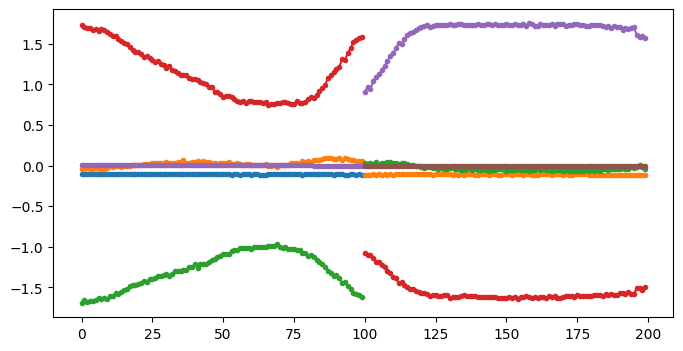

In [68]:
# No temperal agg
plt.figure(figsize=(8, 4))
qpos_gts = []
all_actual_actions = []
action_chunking_len = 100
max_act_steps = 100
step = 0
with torch.inference_mode():
    with h5py.File(h5data_file, "r") as root:
        for index in range(101):
            start_step = index
            if step % action_chunking_len == 0:
                chunk_idx = int(step/action_chunking_len)
                print("Inference at step: ", step)
                qpos_np = root["/observations/qpos"][index]
                qpos_gts.append(qpos_np.copy())
                img_np = root["/observations/images/wrist"][index]
                qpos = pre_process_qpos(qpos_np)
                curr_img = pre_proccess_img(img_np)
                # print("qpos: ",qpos.shape)
                # print("curr_img: ",curr_img.shape)
                all_actions = policy(qpos, curr_img)
                all_actions = all_actions.squeeze(0).cpu().numpy()
                joint_states_traj = []
                actual_actions = []
                steps_plot = np.arange(0, len(all_actions), 1)
                steps_plot = steps_plot + step
                for i, raw_action in enumerate(all_actions):
                    actual_action = post_process_action(raw_action)
                    actual_actions.append(actual_action)
                actual_actions = np.asarray(actual_actions)
                all_actual_actions.append(actual_actions)
                plt.plot(steps_plot, actual_actions[:, 0], marker=".", c="C%i"%(0 + chunk_idx), label='joint0')
                plt.plot(steps_plot, actual_actions[:, 1], marker=".", c="C%i"%(1 + chunk_idx), label='joint1')
                plt.plot(steps_plot, actual_actions[:, 2], marker=".", c="C%i"%(2 + chunk_idx), label='joint2')
                plt.plot(steps_plot, actual_actions[:, 3], marker=".", c="C%i"%(3 + chunk_idx), label='joint3')
                plt.plot(steps_plot, actual_actions[:, 4], marker=".", c="C%i"%(4 + chunk_idx), label='joint4')
            step = step + 1

qpos_gts = np.asarray(qpos_gts)
# plt.xlabel("Time (Step)")
# plt.ylabel("Joint (rad)")
# plt.scatter(len(qpos_gts), qpos_np[0], marker="*", c="b", s=50, label='joint0')
# plt.scatter(len(qpos_gts), qpos_np[1], marker="*", c="b", s=50, label='joint1')
# plt.scatter(len(qpos_gts), qpos_np[2], marker="*", c="b", s=50, label='joint2')
# plt.scatter(len(qpos_gts), qpos_np[3], marker="*", c="b", s=50, label='joint3')
# plt.plot(np.arange(0, len(qpos_gts), 1), qpos_gts, c="r", label='joint5')


# plt.plot(action_obs_np[:, 0], c="g",label='joint0')
# plt.plot(action_obs_np[:, 1], c="g",label='joint1')
# plt.plot(action_obs_np[:, 2], c="g",label='joint2')
# plt.plot(action_obs_np[:, 3], c="g",label='joint3')




In [15]:
all_time_actions.shape

torch.Size([100, 150, 5])

In [18]:
all_time_actions_np = np.zeros([max_act_steps, max_act_steps+action_chunking_len, action_dim])

print(all_time_actions_np[[1], 1:1+action_chunking_len].shape)


(1, 50, 5)


In [17]:
all_time_actions[:, 1].shape

torch.Size([100, 5])

## KDL Forward Kinematics

In [15]:
actual_actions.shape

(100, 5)

In [16]:
def joint_states_to_jnt_array(joint_states):
    # Convert joint states to a KDL JntArray
    kdl_joint_array = PyKDL.JntArray(len(joint_states))
    for i, value in enumerate(joint_states):
        kdl_joint_array[i] = value
    kdl_joint_array
    return kdl_joint_array

def get_frame_pose(fk_solver, kdl_joint_array):
    frame = PyKDL.Frame()
    fk_solver.JntToCart(kdl_joint_array, frame)
    # Extract position and orientation
    position = [frame.p.x(), frame.p.y(), frame.p.z()]
    orientation = [frame.M.GetQuaternion()[0], frame.M.GetQuaternion()[1],
                    frame.M.GetQuaternion()[2], frame.M.GetQuaternion()[3]]
    return position, orientation

def joint_states_to_ee_pose(all_joint_states, fk_solver):
    positions = []
    orientations = []
    for i, joint_states in enumerate(all_joint_states):
        kdl_joint_array = joint_states_to_jnt_array(joint_states)
        position, orientation = get_frame_pose(fk_solver, kdl_joint_array)
        positions.append(position)
        orientations.append(orientation)
        
    positions = np.asarray(positions)
    orientations = np.asarray(orientations)
    return positions, orientations

def plot_3d_trajectory(traj, figsize=(8, 6), title="EE Trajectory"):
    """
    Plots a 3D trajectory with enhanced visualization.

    Args:
        traj (list of lists): The 3D trajectory data, where each inner list represents a point (x, y, z).
        figsize (tuple, optional): Figure size in inches. Defaults to (8, 6).
        title (str, optional): Plot title. Defaults to "3D Trajectory".
    """

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')

    # Plot the trajectory with clear markers and line
    ax.plot(*zip(*traj), color='blue', marker='o', linestyle='-', linewidth=1, markersize=1)

    # Set labels, title, and initial viewpoint
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    # ax.set_xlim(-1, +1)
    # ax.set_ylim(0, 1)
    # ax.set_zlim(0, 0.5)
    ax.set_title(title)
    ax.view_init(elev=20, azim=-60)  # Adjust viewpoint as needed

    # Optional: Add grid and axes limits
    ax.grid(True)
    # Set appropriate limits based on your data range

    plt.show()




In [16]:
(ok, tree)  = kdl_parser_py.urdf.treeFromFile("../z1_robot.xacro")
print("ok: ", ok)
chain = tree.getChain("link00", "link06")  # Replace with actual link names
fk_solver = PyKDL.ChainFkSolverPos_recursive(chain)


ok:  True


In [17]:
all_gt_ee_pose, orientations = joint_states_to_ee_pose(action_obs_np, fk_solver)


In [23]:
all_positions = []
all_orientations = []
plot_len = 500

for i in range(plot_len):
    actual_actions = all_actual_actions[i]
    positions, orientations = joint_states_to_ee_pose(actual_actions, fk_solver)
    all_positions.append(positions)
    all_orientations.append(orientations)

IndexError: list index out of range

In [22]:
len(all_gt_ee_pose)

659

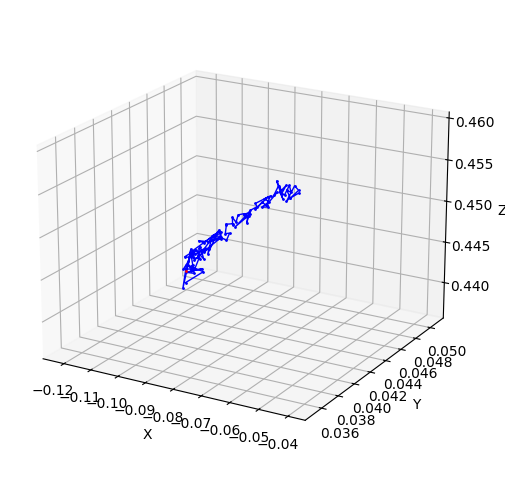

In [20]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot the trajectory with clear markers and line
for traj in all_positions[:plot_len]:
    ax.plot(*zip(*traj), color='blue', marker='o', linestyle='-', linewidth=1, markersize=1)

ax.plot(*zip(*all_gt_ee_pose[:plot_len]), color='red', marker='o', linestyle='-', linewidth=1, markersize=1)

# Set labels, title, and initial viewpoint
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
# ax.set_xlim(-1, +1)
# ax.set_ylim(0, 1)
# ax.set_zlim(0, 0.5)
ax.view_init(elev=20, azim=-60)  # Adjust viewpoint as needed

# Optional: Add grid and axes limits
ax.grid(True)
# Set appropriate limits based on your data range

plt.show() 

In [148]:
all_gt_ee_pose[-1]

array([ 0.44638279, -0.23878488,  0.33308074])

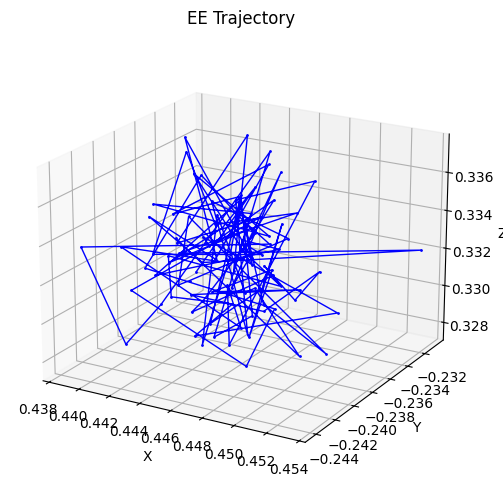

In [149]:
plot_3d_trajectory(positions)

ok:  True


In [44]:
joint_states = [-0.0010887124809900177, 1.4884100482973608, -1.3307996878993358, -0.216861553564872, 0.0002238291478332484, 1.4884889882406714e-05]

In [46]:
kdl_joint_array = joint_states_to_jnt_array(joint_states)

In [47]:
frame = PyKDL.Frame()
fk_solver.JntToCart(kdl_joint_array, frame)
# Extract position and orientation
position = [frame.p.x(), frame.p.y(), frame.p.z()]
orientation = [frame.M.GetQuaternion()[0], frame.M.GetQuaternion()[1],
                frame.M.GetQuaternion()[2], frame.M.GetQuaternion()[3]]

In [48]:
print(position)

[0.31443262989082954, -0.0003313144633375164, 0.48144798208486855]
